# MCMC sampling for dummies

https://twiecki.io/blog/2015/11/10/mcmc-sampling/

In [1]:
%matplotlib inline

import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import norm

sns.set_style('white')
#sns.set_context('talk')

np.random.seed(123)

Lets generate some data: 20 points from a normal centered around zero. 

Our goal will be to estimate the posterior of the mean mu (we'll assume that we know the standard deviation to be 1).

In [2]:
data = np.random.randn(20)

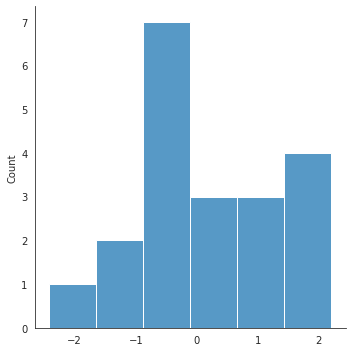

In [3]:
sns.displot(data, kde=False);

## Analytical solution

https://en.wikipedia.org/wiki/Conjugate_prior#When_likelihood_function_is_a_continuous_distribution

In [4]:
def calc_posterior_analytical(data, x, mu_0, sigma_0):
    sigma = 1.
    n = len(data)
    mu_post = (mu_0 / sigma_0**2 + data.sum() / sigma**2) / (1. / sigma_0**2 + n / sigma**2)
    sigma_post = (1. / sigma_0**2 + n / sigma**2)**-1
    return norm(mu_post, np.sqrt(sigma_post)).pdf(x)

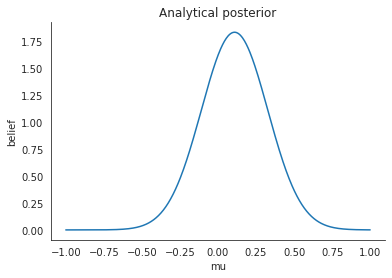

In [5]:
ax = plt.subplot()
x = np.linspace(-1, 1, 500)
posterior_analytical = calc_posterior_analytical(data, x, 0., 1.)
ax.plot(x, posterior_analytical)
ax.set(xlabel='mu', ylabel='belief', title='Analytical posterior');
sns.despine()

## MCMC sampling

In [6]:
mu_current = 1.

proposal_width = 0.5
proposal = norm(mu_current, proposal_width).rvs()

In [7]:
def sampler(data, samples=4, mu_init=.5, proposal_width=.5, plot=False, mu_prior_mu=0, mu_prior_sd=1.):
    
    # starting parameter position
    mu_current = mu_init
    
    posterior = [mu_current]
    
    for i in range(samples):
        # suggest new position
        # You can be very dumb or very sophisticated about how you come up with that proposal. 
        # The Metropolis sampler is very dumb and just takes a sample from a normal distribution 
        # (no relationship to the normal we assume for the model) centered around your current mu 
        # value (i.e. mu_current) with a certain standard deviation (proposal_width) that will 
        # determine how far you propose jumps (here we're use scipy.stats.norm):
        mu_proposal = norm(mu_current, proposal_width).rvs()

        # evaluate whether that's a good place to jump to or not
        # Compute likelihood by multiplying probabilities of each data point
        likelihood_current = norm(mu_current, 1).pdf(data).prod()
        likelihood_proposal = norm(mu_proposal, 1).pdf(data).prod()
        
        # Compute prior probability of current and proposed mu        
        prior_current = norm(mu_prior_mu, mu_prior_sd).pdf(mu_current)
        prior_proposal = norm(mu_prior_mu, mu_prior_sd).pdf(mu_proposal)
        
        p_current = likelihood_current * prior_current
        p_proposal = likelihood_proposal * prior_proposal
        
        # Accept proposal?
        # if p_proposal is larger, that probability will be > 1 and we'll definitely accept. 
        # However, if p_current is larger, say twice as large, there'll be a 50% chance of moving there:
        p_accept = p_proposal / p_current
        
        # Usually would include prior probability, which we neglect here for simplicity
        accept = np.random.rand() < p_accept
        
        if plot:
            plot_proposal(mu_current, mu_proposal, mu_prior_mu, mu_prior_sd, data, accept, posterior, i)
        
        if accept:
            # Update position
            mu_current = mu_proposal
        
        posterior.append(mu_current)
        
    return np.array(posterior)

In [8]:
# Function to display
def plot_proposal(mu_current, mu_proposal, mu_prior_mu, mu_prior_sd, data, accepted, trace, i):
    from copy import copy
    trace = copy(trace)
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(ncols=4, figsize=(16, 4))
    fig.suptitle('Iteration %i' % (i + 1))
    x = np.linspace(-3, 3, 5000)
    color = 'g' if accepted else 'r'
        
    # Plot prior
    prior_current = norm(mu_prior_mu, mu_prior_sd).pdf(mu_current)
    prior_proposal = norm(mu_prior_mu, mu_prior_sd).pdf(mu_proposal)
    prior = norm(mu_prior_mu, mu_prior_sd).pdf(x)
    ax1.plot(x, prior)
    ax1.plot([mu_current] * 2, [0, prior_current], marker='o', color='b')
    ax1.plot([mu_proposal] * 2, [0, prior_proposal], marker='o', color=color)
    ax1.annotate("", xy=(mu_proposal, 0.2), xytext=(mu_current, 0.2),
                 arrowprops=dict(arrowstyle="->", lw=2.))
    ax1.set(ylabel='Probability Density', title='current: prior(mu=%.2f) = %.2f\nproposal: prior(mu=%.2f) = %.2f' % (mu_current, prior_current, mu_proposal, prior_proposal))
    
    # Likelihood
    likelihood_current = norm(mu_current, 1).pdf(data).prod()
    likelihood_proposal = norm(mu_proposal, 1).pdf(data).prod()
    y = norm(loc=mu_proposal, scale=1).pdf(x)
    sns.histplot(data, kde=False, ax=ax2, stat='probability')
    ax2.plot(x, y, color=color)
    ax2.axvline(mu_current, color='b', linestyle='--', label='mu_current')
    ax2.axvline(mu_proposal, color=color, linestyle='--', label='mu_proposal')
    #ax2.title('Proposal {}'.format('accepted' if accepted else 'rejected'))
    ax2.annotate("", xy=(mu_proposal, 0.2), xytext=(mu_current, 0.2),
                 arrowprops=dict(arrowstyle="->", lw=2.))
    ax2.set(title='likelihood(mu=%.2f) = %.2f\nlikelihood(mu=%.2f) = %.2f' % (mu_current, 1e14*likelihood_current, mu_proposal, 1e14*likelihood_proposal))
    
    # Posterior
    posterior_analytical = calc_posterior_analytical(data, x, mu_prior_mu, mu_prior_sd)
    ax3.plot(x, posterior_analytical)
    posterior_current = calc_posterior_analytical(data, mu_current, mu_prior_mu, mu_prior_sd)
    posterior_proposal = calc_posterior_analytical(data, mu_proposal, mu_prior_mu, mu_prior_sd)
    ax3.plot([mu_current] * 2, [0, posterior_current], marker='o', color='b')
    ax3.plot([mu_proposal] * 2, [0, posterior_proposal], marker='o', color=color)
    ax3.annotate("", xy=(mu_proposal, 0.2), xytext=(mu_current, 0.2),
                 arrowprops=dict(arrowstyle="->", lw=2.))
    #x3.set(title=r'prior x likelihood $\propto$ posterior')
    ax3.set(title='posterior(mu=%.2f) = %.5f\nposterior(mu=%.2f) = %.5f' % (mu_current, posterior_current, mu_proposal, posterior_proposal))
    
    if accepted:
        trace.append(mu_proposal)
    else:
        trace.append(mu_current)
    ax4.plot(trace)
    ax4.set(xlabel='iteration', ylabel='mu', title='trace')
    plt.tight_layout()
    plt.show()
    #plt.legend()

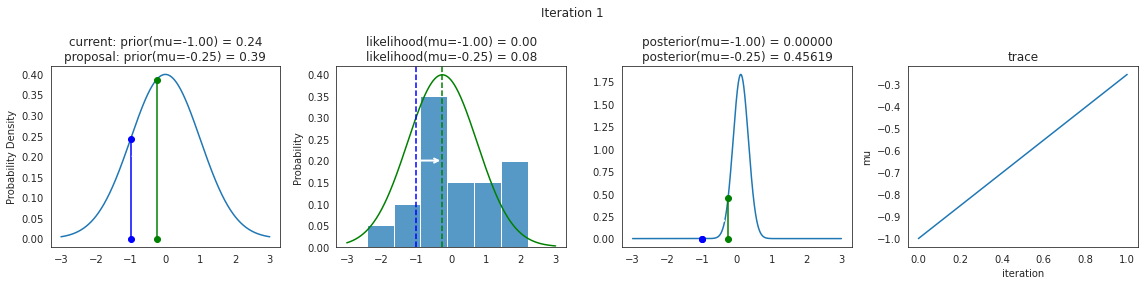

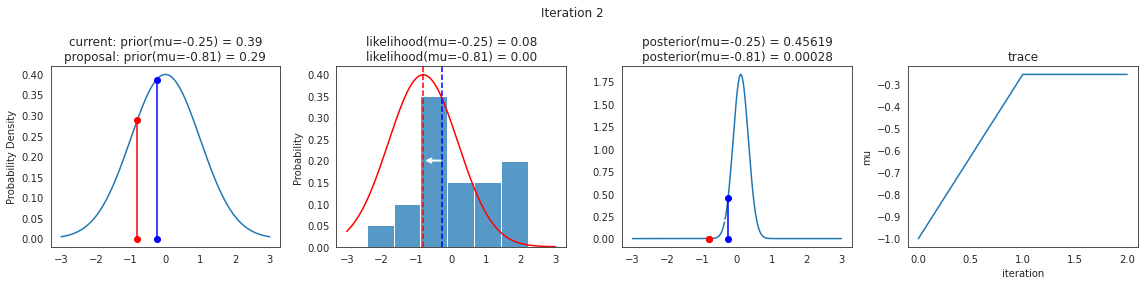

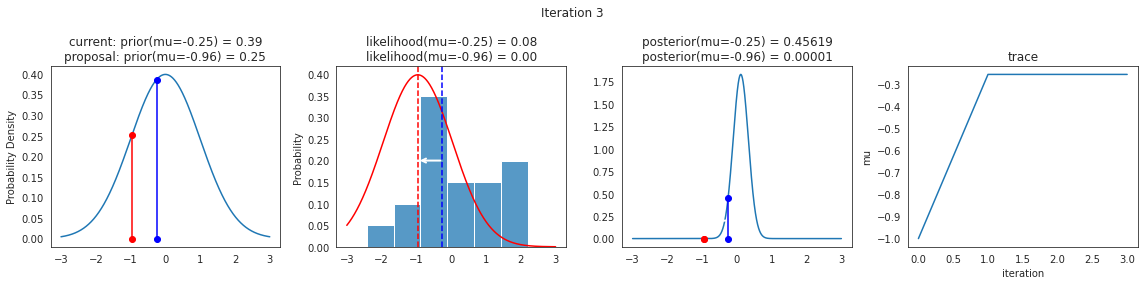

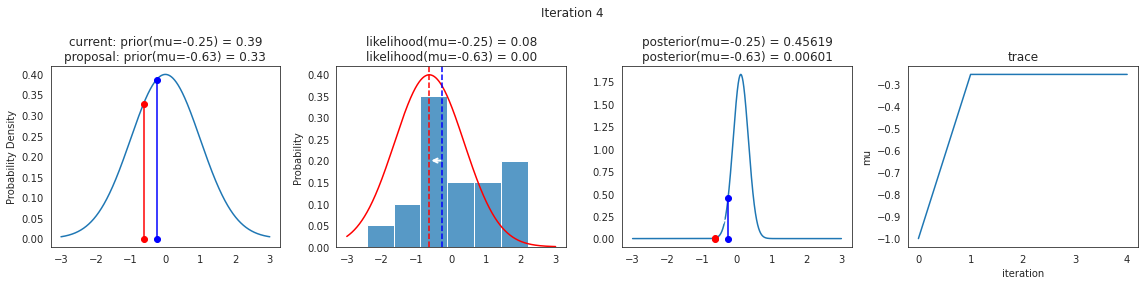

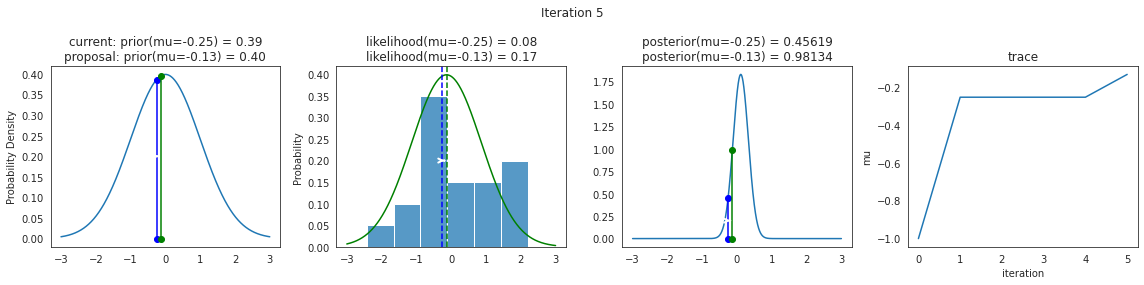

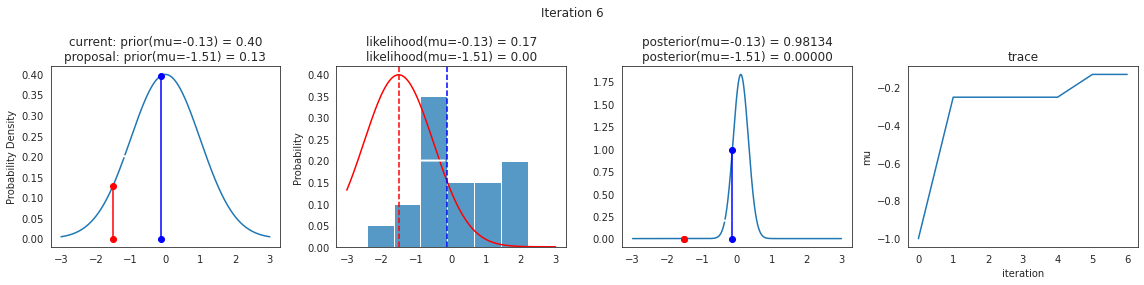

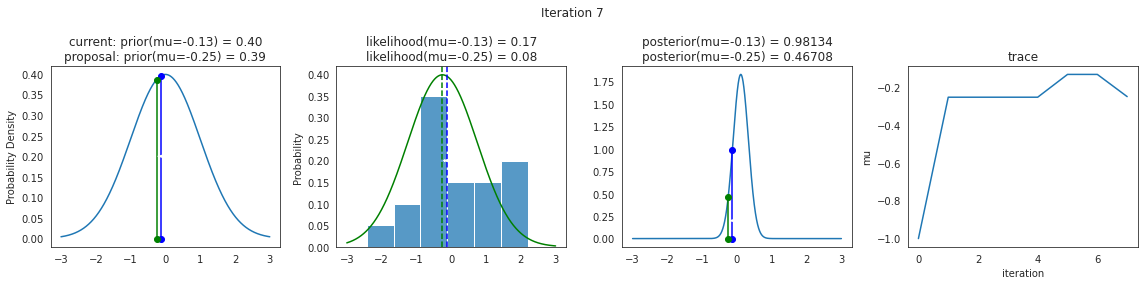

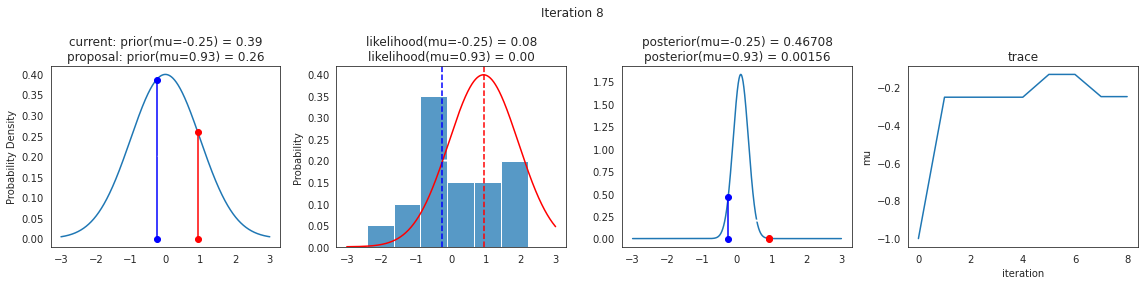

In [9]:
sampler(data, samples=8, mu_init=-1., plot=True);

In [10]:
posterior = sampler(data, samples=15000, mu_init=1.)

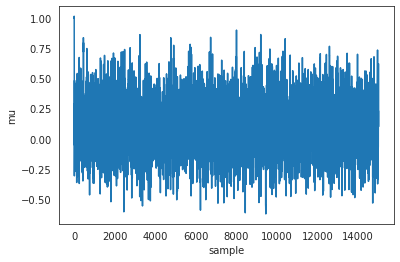

In [11]:
fig, ax = plt.subplots()
ax.plot(posterior)
ax.set(xlabel='sample', ylabel='mu');

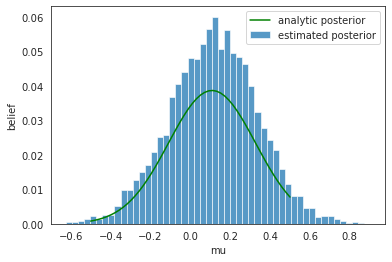

In [12]:
ax = plt.subplot()
sns.histplot(posterior[500:], ax=ax, label='estimated posterior', stat='probability', bins=50)
x = np.linspace(-.5, .5, 50)
post = calc_posterior_analytical(data, x, 0, 1)
post /= post.sum()
ax.plot(x, post, 'g', label='analytic posterior')
ax.set(xlabel='mu', ylabel='belief');
ax.legend();

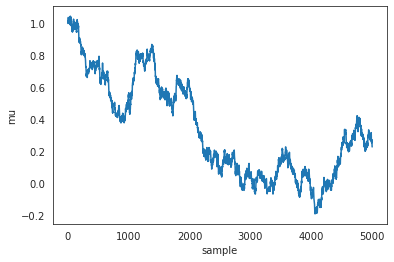

In [13]:
posterior_small = sampler(data, samples=5000, mu_init=1., proposal_width=.01)
fig, ax = plt.subplots()
ax.plot(posterior_small);
ax.set(xlabel='sample', ylabel='mu');

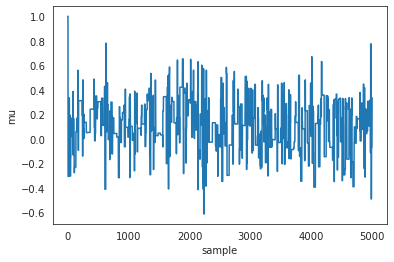

In [14]:
posterior_large = sampler(data, samples=5000, mu_init=1., proposal_width=3.)
fig, ax = plt.subplots()
ax.plot(posterior_large); plt.xlabel('sample'); plt.ylabel('mu');
ax.set(xlabel='sample', ylabel='mu');

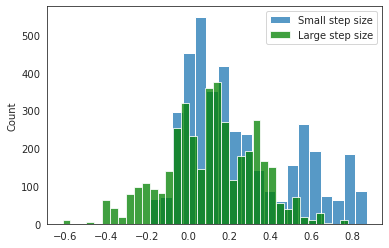

In [15]:
fig, ax = plt.subplots()
sns.histplot(posterior_small[1000:], label='Small step size', ax=ax)
sns.histplot(posterior_large[1000:], label='Large step size', ax=ax, color='g');
ax.legend();

The key is that we want our samples to be independent of each other which cleary isn't the case here. Thus, one common metric to evaluate the efficiency of our sampler is the autocorrelation -- i.e. how correlated a sample i is to sample i-1, i-2, etc:

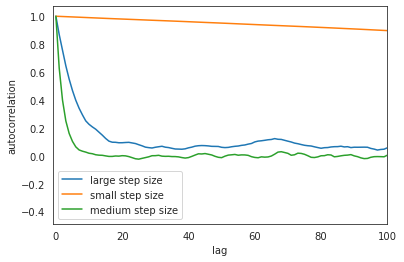

In [29]:
from pymc3.stats import autocorr

fig, ax = plt.subplots()
ax.plot(autocorr(posterior_large), label='large step size')
ax.plot(autocorr(posterior_small), label='small step size')
ax.plot(autocorr(posterior), label='medium step size')
ax.legend(loc=0)
ax.set(xlabel='lag', ylabel='autocorrelation', xlim=(-1, 100));

## With PyMC3

In [30]:
import pymc3 as pm

In [39]:
with pm.Model():
    mu = pm.Normal('mu', 0, 1)
    sigma = 1.
    returns = pm.Normal('returns', mu=mu, sd=sigma, observed=data)
    
    step = pm.Metropolis()
    trace = pm.sample(15000, step, chains=1)

/tmp/sconseil/ipykernel_374024/3750463006.py:7: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(15000, step, chains=1)
Sequential sampling (1 chains in 1 job)
Metropolis: [mu]


Sampling 1 chain for 1_000 tune and 15_000 draw iterations (1_000 + 15_000 draws total) took 3 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


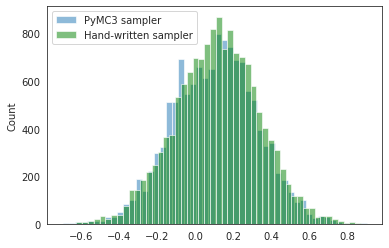

In [40]:
fig, ax = plt.subplots()
sns.histplot(trace[2000:]['mu'], label='PyMC3 sampler', ax=ax, bins=50, alpha=0.5);
sns.histplot(posterior[500:], label='Hand-written sampler', ax=ax, bins=50, color='g', alpha=0.5);
plt.legend();

In [41]:
with pm.Model():
    mu = pm.Normal('mu', 0, 1)
    sigma = pm.Normal('sigma', 1, 1)
    returns = pm.Normal('returns', mu=mu, sd=sigma, observed=data)
    
    step = pm.Metropolis()
    trace = pm.sample(15000, step, chains=1)

/tmp/sconseil/ipykernel_374024/2311697439.py:7: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(15000, step, chains=1)
Sequential sampling (1 chains in 1 job)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [mu]


Sampling 1 chain for 1_000 tune and 15_000 draw iterations (1_000 + 15_000 draws total) took 6 seconds.
/home/sconseil/.pyenv/versions/miniconda3-latest/lib/python3.8/site-packages/arviz/data/base.py:169: UserWarning: More chains (15000) than draws (2). Passed array should have shape (chains, draws, *shape)
  warnings.warn(
Only one chain was sampled, this makes it impossible to run some convergence checks


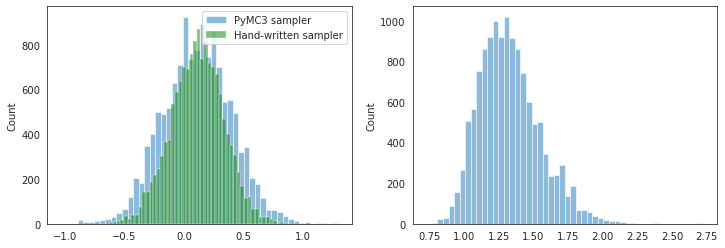

In [42]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
sns.histplot(trace[2000:]['mu'], label='PyMC3 sampler', ax=ax1, bins=50, alpha=0.5);
sns.histplot(posterior[500:], label='Hand-written sampler', ax=ax1, bins=50, color='g', alpha=0.5);
ax1.legend();
sns.histplot(trace[2000:]['sigma'], label='PyMC3 sampler', ax=ax2, bins=50, alpha=0.5);

## PyMC3 tutorial

In [43]:
with pm.Model() as model:
    mu = pm.Normal("mu", mu=0, sigma=1)
    obs = pm.Normal("obs", mu=mu, sigma=1, observed=np.random.randn(100))
    idata = pm.sample(2000, tune=1500, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu]


Sampling 4 chains for 1_500 tune and 2_000 draw iterations (6_000 + 8_000 draws total) took 4 seconds.


In [45]:
idata.posterior

<xarray.Dataset>
Dimensions:  (chain: 4, draw: 2000)
Coordinates:
  * chain    (chain) int64 0 1 2 3
  * draw     (draw) int64 0 1 2 3 4 5 6 7 ... 1993 1994 1995 1996 1997 1998 1999
Data variables:
    mu       (chain, draw) float64 0.01154 0.01154 -0.1962 ... 0.02515 0.01566
Attributes:
    created_at:                 2022-02-18T17:19:44.545959
    arviz_version:              0.11.2
    inference_library:          pymc3
    inference_library_version:  3.11.2
    sampling_time:              4.426003456115723
    tuning_steps:               1500

In [49]:
import arviz as az

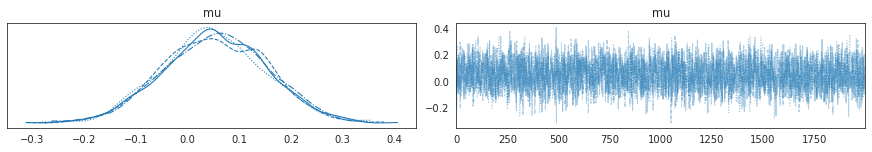

In [50]:
az.plot_trace(idata);

In [51]:
az.summary(idata)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu,0.053,0.099,-0.135,0.231,0.002,0.001,3619.0,5423.0,1.0


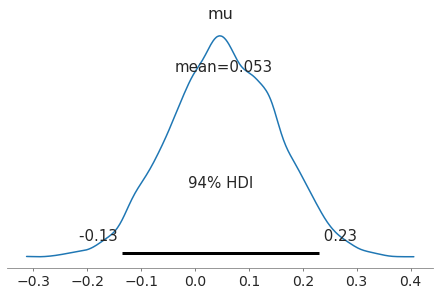

In [52]:
az.plot_posterior(idata);

### PyMC3 samplers

In [46]:
list(filter(lambda x: x[0].isupper(), dir(pm.step_methods)))

['BinaryGibbsMetropolis',
 'BinaryMetropolis',
 'CategoricalGibbsMetropolis',
 'CauchyProposal',
 'CompoundStep',
 'DEMetropolis',
 'DEMetropolisZ',
 'DEMetropolisZMLDA',
 'ElemwiseCategorical',
 'EllipticalSlice',
 'HamiltonianMC',
 'LaplaceProposal',
 'MLDA',
 'Metropolis',
 'MetropolisMLDA',
 'MultivariateNormalProposal',
 'NUTS',
 'NormalProposal',
 'PGBART',
 'PoissonProposal',
 'RecursiveDAProposal',
 'Slice',
 'UniformProposal']